In [1]:
import numpy as np
import pandas as pd
import time
import sys
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import random
import scipy
from scipy.optimize import curve_fit
import scipy.optimize as op
import matplotlib.colors as colors
from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']


from multihist import Histdd

import logging
logging.getLogger('hax.minitrees').setLevel(logging.INFO)

#from lax.lichen import Lichen
#import lichens as se_cuts

In [2]:
params = {
    'font.family': 'serif',
    'font.size' : 24, 'axes.titlesize' : 42, 'axes.labelsize' : 32, 'axes.linewidth' : 2,
    # ticks
    'xtick.labelsize' : 24, 'ytick.labelsize' : 24, 'xtick.major.size' : 16, 'xtick.minor.size' : 8,
    'ytick.major.size' : 16, 'ytick.minor.size' : 8, 'xtick.major.width' : 2, 'xtick.minor.width' : 2,
    'ytick.major.width' : 2, 'ytick.minor.width' : 2, 'xtick.direction' : 'in', 'ytick.direction' : 'in',
    # markers
    'lines.markersize' : 8, 'lines.markeredgewidth' : 2, 'errorbar.capsize' : 5, 'lines.linewidth' : 2,
    #'lines.linestyle' : None, 'lines.marker' : None,
    'savefig.bbox' : 'tight', 'legend.fontsize' : 24,
    'axes.labelsize': 24, 'axes.titlesize':24, 'xtick.labelsize':18, 'ytick.labelsize':18,
    'backend': 'Agg', 'mathtext.fontset': 'dejavuserif',
    'figure.facecolor':'w',
    #pad
    'axes.labelpad':12,
    # ticks
    'xtick.major.pad': 6,   'xtick.minor.pad': 6,   
    'ytick.major.pad': 3.5, 'ytick.minor.pad': 3.5,
}
plt.rcParams.update(params)

In [3]:
xenon_density = 0.002862 #kg/cm^3 
z = tpc_height # cm
time_ns_to_s = 1/1e9 # s
time_s_to_days = 1/60/60/24 # days
mass_kg_to_tonne = 1/1000 # tonne

drift_velocity = 1 # mm/us
x_mm_to_cm = 1/10 # cm
time_ns_to_us = 1/1000 # us

## Loading data and some preliminary checks

In [4]:
#data_combine = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/180706_1451_lonehit_combined_Aug2020.h5')

data_combine = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/180706_1451_lonehit_combined_Nov2022.h5')

In [5]:
# limiting the data to the time of lonehits
data_lh = data_combine[data_combine['type_digit']==0]
data = data_combine[data_combine['gcenter_time'] < max(data_lh['gcenter_time'])]
data = data[data['gcenter_time'] > min(data_lh['gcenter_time'])]

In [6]:
#to conserve memory
del data_lh, data_combine

In [7]:
#since time can't be negative
data = data[data['gcenter_time_primary'] > 0]
data = data.sort_values('gcenter_time')
data = data.reset_index(drop=True)

## Calculating the amount of time to be considered after a primary
Taken from https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/000_GetRates_everything.ipynb

In [8]:
df_prim = data.drop_duplicates(['gcenter_time_primary'])
df_prim = df_prim.sort_values('gcenter_time')
df_prim = df_prim.reset_index(drop=True)


In [9]:

window = np.zeros(len(data))

p_ind = 1
next_prim_time = df_prim['gcenter_time_primary'].values[p_ind]


for i in tqdm.trange(len(data)):
    window[i] = next_prim_time - data['gcenter_time_primary'].values[i]
    
    if i == len(data) - 1:
            break
    
    elif (i < len(data)) & (data['gcenter_time_primary'].values[i+1] == next_prim_time):
        p_ind += 1
        
        if p_ind <= len(df_prim)-1:
            next_prim_time = df_prim['gcenter_time_primary'].values[p_ind]
        else:
            next_prim_time = data['gcenter_time'].values[-1]

data['livetime_new'] = window

100%|█████████▉| 63718606/63718607 [08:23<00:00, 126601.74it/s]


In [10]:
len(df_prim)

107121

In [11]:
del df_prim, window

## Finding time-difference between lonehit and previous primary 
Taken from Amanda/single_photons/lonehits_gas.ipynb

In [12]:
time_pre_1 = -np.inf*np.ones(len(data))
maxt = 2e9
second_prim_time = -100e9


for i in tqdm.trange(len(data)):
    time_pre_1[i] = data['gcenter_time_primary'].values[i] - second_prim_time

    if i == len(data) - 1:
        break
    elif (i < len(data)) & (data['gcenter_time_primary'].values[i] == data['gcenter_time_primary'].values[i+1]):
        pass
    else:
        second_prim_time = data['gcenter_time_primary'].values[i]

data['time_pre_1'] = time_pre_1


100%|█████████▉| 63718606/63718607 [11:17<00:00, 93993.22it/s]


In [13]:
del time_pre_1

## Overlap Cut (time-shadow)
Taken from https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L190

In [14]:
from scipy.integrate import quad
def _process(df):
        """
        """
        def power(x, a, b):
            return a * x ** -b
        
        gamma = 1
        percent = 0.5 #50% purity 
        max_dt = 1e9
        #bounds for integration
        t_0 = 2e6
        t_1 = 200e6
        R_1 = [0,0]

        primary_time_variable = 'gcenter_time_primary'
        peak_time_variable = 'gcenter_time'
        primary_area_variable = 'area_primary'
        
        df_unique =df.drop_duplicates([primary_time_variable])
        pass_cut=np.zeros(len(df))
        window_length=np.zeros(len(df))
        counter=0
        for index, primary in (df_unique.iterrows()):

            R_0_tot = 0
            win = -1
            next_index = np.nan
            if index == df_unique.index[0]:
                counter+=1
                continue

            else:
                if counter<len(df_unique)-1:
                    next_index=df_unique.index[counter+1]
                    win = df_unique[primary_time_variable].iloc[counter+1] - df_unique[primary_time_variable].iloc[counter]
                    window_length[index:next_index]=win

                else:
                    next_index=len(df)
                    win = df[peak_time_variable].iloc[-1] - df_unique[primary_time_variable].iloc[counter]
                    window_length[index:next_index]=win

                for k in range(counter-1,-1,-1):

                    if np.abs((df_unique[primary_time_variable].iloc[counter]-df_unique[primary_time_variable].iloc[k])) <= max_dt:

                        t_counter = df_unique[primary_time_variable].iloc[counter]
                        t_k = df_unique[primary_time_variable].iloc[k]

                        amp_counter = df_unique[primary_area_variable].iloc[counter]
                        amp_k = df_unique[primary_area_variable].iloc[k]

                        R_1 = quad(power, t_0, t_1, args=(amp_counter,gamma))
                        R_0 = quad(power, (t_counter-t_k)+t_0, (t_counter-t_k)+t_1, args=(amp_k,gamma))
                        R_0_tot += R_0[0]

                    else:
                        break


                if R_0_tot <= 0:
                    R_0_tot = 0

                if R_1[0] == 0:
                    sum_ratio = 0
                else:
                    sum_ratio = R_1[0]/(R_0_tot+R_1[0])

                if sum_ratio >= percent:
                    pass_cut[index:next_index]=1

            counter += 1
        df.loc[:,'ClusterCut_power']=pass_cut
        df.loc[:,'livetime_old']=window_length
        
        df.loc[:, 'CutOverlap'] = (df['ClusterCut_power'] == 1)
        return df

In [15]:
data = _process(data)


/tmp/ipykernel_3140498/3801863758.py:55: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  R_0 = quad(power, (t_counter-t_k)+t_0, (t_counter-t_k)+t_1, args=(amp_k,gamma))
/tmp/ipykernel_3140498/3801863758.py:55: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  R_0 = quad(power, (t_counter-t_k)+t_0, (t_counter-t_k)+t_1, args=(amp_k,gamma))
/tmp/ipykernel_3140498/3801863758.py:55: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, a

In [16]:
data = data[(data.CutOverlap)]

In [17]:
df = data[(data['type_digit'] == 2.0) 
          | (data['type_digit'] == 0.0)]

In [18]:
del data

### Also removing events within 6 microseconds of single-electrons
Amanda/single_photons/lonehits_gas.ipynb

In [19]:
time = 6000  # 6 microseconds 
times_col = df['gcenter_time'].values
type_col = df['type_digit'].values
maxtime = max(times_col)
drop_this = []

for i in tqdm.trange((len(df)-1)):
    if type_col[i] == 2.0:
        time1 = times_col[i]
        time2 = time1 + time
        if time2 > maxtime:
            time2 = maxtime
        start = i + 1
        end = i + 20 
        if start >= (len(df)-1):
            start = len(df)-1
        if end >= (len(df)-1):
            end = len(df)-1
        for n in range(start, end):
            if ((type_col[n] == 0) &(times_col[n] > time1) & (times_col[n] < time2)):
                drop_this.append(n)

100%|██████████| 33213903/33213903 [00:22<00:00, 1446609.60it/s]


In [20]:
df = df.drop(df.index[drop_this])

In [21]:
del times_col, type_col, drop_this

In [22]:
print(len(pd.unique(df['gcenter_time_primary'])))

41610


### Pretrigger and Livetime Cut
Taken from https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/000_GetRates_everything.ipynb

In [23]:
pre_trigger = 1e6
data_cut = df[df['livetime_new'] > pre_trigger] #remove events with livetimes < 1 ms
data_cut = data_cut[(data_cut['livetime_new'].values-data_cut['dt_primary'].values) > pre_trigger] #remove e- within 1 ms of next prim
data_cut = data_cut[data_cut['livetime_new'].values*time_ns_to_s < 5] #max livetime is 5s

data_cut['event_window_seconds'] = (data_cut['livetime_new'].values - pre_trigger)*time_ns_to_s #reduce livetime by 1 ms
data_cut['delay_time_seconds'] = (data_cut['dt_primary'].values)*time_ns_to_s #convert delay time to seconds
del(df)

## Cuts for selecting primaries in liquid

In [24]:
# AFT cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L31
from scipy.interpolate import interp1d

def lower_limit_s2_aft(s2):
    return 0.6648160611018054 - 2.590402853814859e-07 * np.clip(s2, 0, 50000) - 0.8531029789184852 / np.log(np.clip(s2, 0, 50000))


def upper_limit_s2_aft_l(s2):
    extended_upper_bound = np.load('ExtendedUpperBand.npz')
    upper_band_interp =  interp1d(extended_upper_bound['x_bins'], 
                              extended_upper_bound['combined_upper'], 
                              bounds_error=False, fill_value = (extended_upper_bound['combined_upper'][0],
                                                              extended_upper_bound['combined_upper'][-1]),
                                kind="linear")
    return upper_band_interp(s2)

data_liquid = data_cut[data_cut['area_fraction_top_primary'] < upper_limit_s2_aft_l(data_cut['area_primary'])]
data_liquid = data_liquid[data_liquid['area_fraction_top_primary'] > lower_limit_s2_aft(data_liquid['area_primary'])]


In [25]:
# Width cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L105

data_liquid = data_liquid[(data_liquid['wr_avg_primary'] > 120) & (data_liquid['wr_avg_primary'] < 2500)]


In [27]:
# Threshold cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L160
#I have changed it from 1e4 to 3e4 because otherwise normalization was changing the slope (see hist.png in this folder)
data_prim = data_liquid[data_liquid['dt_primary'] == 0]
plt.hist(data_prim['area_primary'],bins=np.logspace(3,7,100))
plt.xscale('log')
plt.axvline(1e4)
plt.xlabel('Primary Area [PE]')
plt.show()
data_liquid = data_liquid[data_liquid['area_primary'] > 30000]


In [28]:
data_prim = data_cut[data_cut['dt_primary'] == 0]
plt.hist(data_prim['area_primary'],bins=np.logspace(3,7,100))
plt.xscale('log')
plt.axvline(3e4)
plt.xlabel('Primary Area [PE]')
plt.show()

## Cuts for selecting primaries in gas

In [29]:
# AFT cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L31
def upper_limit_s2_aft_g(s2):
    return 0.7 + 1e-06 * np.clip(s2, 0, 200000) + 0.3/ np.log(np.clip(s2, 0, 50000))
data_gas = data_cut[data_cut['area_fraction_top_primary'] > upper_limit_s2_aft_g(data_cut['area_primary'])]


In [30]:
# Width cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L105

data_gas = data_gas[(data_gas['wr_avg_primary'] > 120) & (data_gas['wr_avg_primary'] < 2500)]

In [31]:
# Threshold cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L160

data_prim = data_gas[data_gas['dt_primary'] == 0]
plt.hist(data_prim['area_primary'],bins=np.logspace(3,7,100))
plt.xscale('log')
plt.axvline(2e3)
plt.xlabel('Primary Area [PE]')
plt.show()
data_gas = data_gas[data_gas['area_primary'] > 2000]


In [32]:
data_prim = data_liquid[data_liquid['dt_primary'] == 0]
plt.hist(data_prim['area_primary'],bins=np.logspace(2,7,100))
plt.xscale('log')
plt.axvline(2e3)
plt.xlabel('Primary Area [PE]')
plt.show()

In [33]:
del data_cut

## Selecting lone-hits occuring in good PMTs

In [34]:
good_pmts = [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  62,  63,  64,  65,  67,  68,
         69,  70,  72,  73,  74,  75,  76,  77,  79,  80,  81,  82,  83,
         84,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
        111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124,
        125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 143, 144, 145, 146, 147, 148, 149, 150, 151,
        152, 153, 154, 155, 156, 158, 159, 160, 161, 162, 163, 164, 165,
        166, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
        180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
        193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
        206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 218, 219,
        220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
        233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247]

In [35]:
def good_lonehits(data_cut):
    data_sp = data_cut[(data_cut['type_digit'] == 0)]
    data_sp = data_sp[data_sp['lone_hit_channel'].isin(good_pmts)]
    return data_sp

In [36]:
data_sp_gas = good_lonehits(data_gas)
data_sp_liquid = good_lonehits(data_liquid)

## Power law plots
Functions taken from https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/000_GetRates_everything.ipynb

In [37]:
#hist bins in seconds
hist_bins_start = -4
hist_bins_stop = 0
hist_num_bins = 100

hist_bins = np.logspace(hist_bins_start,hist_bins_stop,hist_num_bins+1)

In [38]:
def power(x, a, b):
    return a * x ** b

In [39]:
def MLEpower(bins,counts,windows,guesses, eff, pur):
    #Get the corresponding x values, and the bin and window correction
    x = []
    c = []
    r = []
    for i in range(len(bins) - 1):
        x.append((bins[i+1] + bins[i])/2)
        c.append((bins[i+1] - bins[i])*eff*windows[i]/pur)
    #Do the MLE
    def MLE(p):
        L = 0
        for i in range(len(x)):
            f_i = p[0]*((x[i])**p[1])
            L += ( c[i]*f_i - counts[i]*np.log(c[i]*f_i) )
        return L

    results = op.minimize(MLE, guesses, method = 'Nelder-Mead', options={'disp': True, 'maxiter': 1e3})
    A_MLE = results['x'][0]
    b_MLE = results['x'][1]

    #Find the error
    In_A = 0
    In_b = 0

    for i in range(len(x)):
        In_A += counts[i]/(A_MLE**2) 
        In_b += c[i]*A_MLE*(x[i]**b_MLE)*(np.log(x[i])**2)


    errA = np.sqrt(len(x)/In_A)
    errb = np.sqrt(len(x)/In_b)

    
    return A_MLE,b_MLE,errA,errb

In [51]:
# I have removed normalization in this function

def get_frac(df, df_prim, fit_lower=2*1e-3, fit_upper=200*1e-3, s2_lower=150, s2_upper=1e7, pre_1_lower=0.2, pre_1_upper=10, correction ='xy'):
        
    df_here = df
        
    primary_area = df_here['area_primary']
    primary_area_prim = df_prim['area_primary']

    
    df_here = df_here[
                    (primary_area > s2_lower)
                    & (primary_area <= s2_upper)
                    & (df_here['time_pre_1']/1e9 > 0.05)
                    & (df_here['time_pre_1']/1e9 <= pre_1_upper)
#                     & (df_here['event_window_seconds'] > 0.2)
                    ]
    
    df_prim_here = df_prim[
                    (primary_area_prim > s2_lower)
                    & (primary_area_prim <= s2_upper)
                    & (df_prim['time_pre_1']/1e9 > 0.05)
                    & (df_prim['time_pre_1']/1e9 <= pre_1_upper)
#                     & (df_prim['event_window_seconds'] > 0.2)
                    ]

    

    
        
    se = 28.3

    # Counts histogram 
    f_counts = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins)
    bin_heights = f_counts[0]
    bin_width = f_counts[1][1:] - f_counts[1][:-1]
    bin_centers = f_counts[1][:-1] + 0.5*bin_width

    f_counts_corrected = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins,)
    f_counts_corrected_error_hist,_ = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins,)
    f_counts_corrected_errorbar = np.sqrt(f_counts_corrected_error_hist)
    plt.figure()
    plt.errorbar(bin_centers ,f_counts_corrected[0]/bin_width/len(df_prim_here), 
                 f_counts_corrected_errorbar/bin_width/len(df_prim_here) ,
                 ecolor ='r' ,fmt='none' ,drawstyle = 'steps-mid')
    plt.xlabel('Delay time [s]')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    
    ### Livetime Plot
    df_unique = df_prim_here.drop_duplicates(['gcenter_time_primary'])
    window_bin_widths = hist_bins[1:]-hist_bins[:-1]
    df_unique['WindowBin'] = np.digitize(df_unique.event_window_seconds, bins=hist_bins)
    df_unique = df_unique.mask(df_unique.WindowBin>hist_num_bins-1, hist_num_bins-1)
    print (len(df_unique))

    f_livetime_full = plt.hist(hist_bins[df_unique.WindowBin-1], bins=hist_bins,  cumulative=-1)
    f_livetime_full_err = np.sqrt(f_livetime_full[0])
    plt.errorbar(bin_centers ,f_livetime_full[0], f_livetime_full_err ,ecolor ='r' ,fmt='none' ,drawstyle = 'steps-mid')

    f_livetime_part = np.histogram(df_unique.event_window_seconds, weights=(df_unique.event_window_seconds
                         -hist_bins[df_unique.WindowBin-1])/window_bin_widths[df_unique.WindowBin-1], bins=hist_bins)
    f_livetime_part_err = np.sqrt(f_livetime_part[0])
    plt.errorbar(bin_centers ,f_livetime_part[0], f_livetime_part_err ,ecolor ='r' , fmt='none' , drawstyle = 'steps-mid')
    plt.close()
    
    # Calculate rate
    
    count = f_counts_corrected[0]/bin_width
    livetime = f_livetime_full[0]+f_livetime_part[0]
    window_err = np.sqrt(livetime)
    
    
    plt.figure()
    plt.errorbar(bin_centers,livetime, yerr=window_err, linestyle='', color='r', marker='.')
    plt.xlabel('Livetime [s]')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    
    rate = count/livetime
    rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
    weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])

    # mask for the fit range
    mask = ((bin_centers > fit_lower) & (bin_centers <= fit_upper))
    centers_fit = bin_centers[mask]
    rate_fit = rate[mask]
    error_fit = rate_err[mask]
    width_fit = bin_width[mask]
    count_fit = f_counts[0][mask]
    livetime_fit = livetime[mask]/weight_factor[mask]
    

    guess = [1e-10,-1.2]

    results = MLEpower(centers_fit[:-1], count_fit[:-1], livetime_fit[:-1], guess, 1, 1)

    plt.close()

    return rate, rate_err, bin_centers, centers_fit, results

In [52]:
rate_g, rate_err_g, bin_centers, centers_fit, results_g = get_frac(data_sp_gas, data_gas)
rate_l, rate_err_l, bin_centers, centers_fit, results_l= get_frac(data_sp_liquid, data_liquid)


/tmp/ipykernel_3140498/511227213.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['WindowBin'] = np.digitize(df_unique.event_window_seconds, bins=hist_bins)
/tmp/ipykernel_3140498/511227213.py:84: RuntimeWarning: invalid value encountered in divide
  rate = count/livetime
/tmp/ipykernel_3140498/511227213.py:85: RuntimeWarning: invalid value encountered in divide
  rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
/tmp/ipykernel_3140498/511227213.py:86: RuntimeWarning: invalid value encountered in divide
  weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])


27
Optimization terminated successfully.
         Current function value: -20094.358647
         Iterations: 251
         Function evaluations: 465
18157
Optimization terminated successfully.
         Current function value: -184475258.586156
         Iterations: 258
         Function evaluations: 481


/tmp/ipykernel_3140498/511227213.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['WindowBin'] = np.digitize(df_unique.event_window_seconds, bins=hist_bins)


In [53]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers,rate_g, yerr=rate_err_g,color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid')
l1 = ('gas Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_g[0], results_g[2], results_g[1], results_g[3]))
plt.annotate(l1, xy=(1e-3, 3.7e4), fontsize=20, color='m')

curvey1 = power(centers_fit, results_g[0],results_g[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$ s^{-1} $]')

# plt.ylim(1e-6,1e1)
plt.legend(loc=3)
plt.xticks()
plt.yticks()
plt.savefig('gas_only')
plt.show()

/tmp/ipykernel_3140498/3501822962.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [57]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers[:-1],rate_g[:-1], yerr=rate_err_g[:-1],color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid',label='lonehits due to gas S2s')
l1 = ('gas Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_g[0], results_g[2], results_g[1], results_g[3]))
plt.annotate(l1, xy=(7e-3, 3.7e4), fontsize=20, color='m')
plt.errorbar(bin_centers[:-1],rate_l[:-1], yerr=rate_err_l[:-1], fmt='.' ,drawstyle = 'steps-mid',label='lonehits due to liquid S2s')
l1 = ('liquid Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_l[0], results_l[2], results_l[1], results_l[3]))
plt.annotate(l1, xy=(7e-3, 5e4), fontsize=20, color='b')
curvey1 = power(centers_fit,results_g[0],results_g[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')
curvey1 = power(centers_fit, results_l[0],results_l[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='b')
plt.axhline(2.1*10**3,color='red')
plt.axhline(10**3*0.9,color='orange')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$ s^{-1} $]')
# plt.ylim(1e-6,1e1)
#plt.legend(loc=3)
plt.xticks()
plt.yticks()
plt.savefig('try')
plt.show()

/tmp/ipykernel_3140498/2634728431.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')
/tmp/ipykernel_3140498/2634728431.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='b')


/depot/darkmatter/etc/conda/env/analysis/lib/python3.4/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


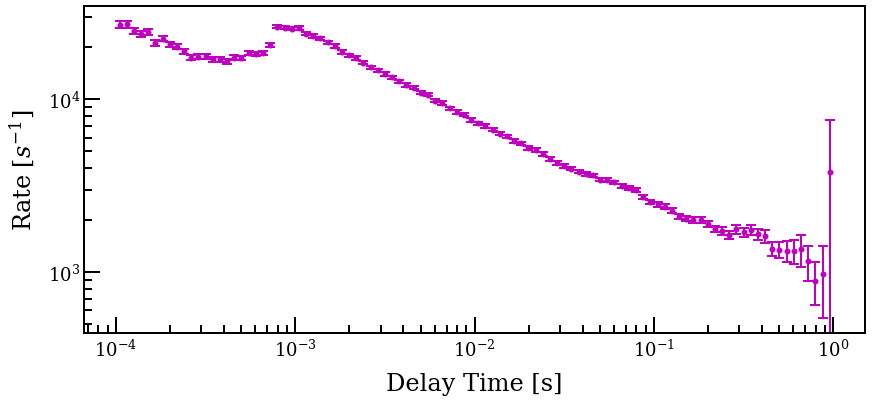

In [79]:
### Don't run this. It is the proof that I can reproduce the Amanda's plot if I apply AFT-cut for liquid on gas primaries. 

fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers,rate_g, yerr=rate_err_g,color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid')
#l1 = ('1e Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results[0], results[2], results[1], results[3]))

#curvey1 = power(centers_fit, results[0],results[1])

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$ s^{-1} $]')
# plt.ylim(1e-6,1e1)
plt.legend(loc=3)
plt.xticks()
plt.yticks()
plt.show()

In [44]:
# I am normalizing by primary_area instead of n_electrons = primary_area/se.
def get_frac(df, df_prim, fit_lower=2*1e-3, fit_upper=200*1e-3, s2_lower=150, s2_upper=1e7, pre_1_lower=0.2, pre_1_upper=10, correction ='xy'):
        
    df_here = df
        
    primary_area = df_here['area_primary']
    primary_area_prim = df_prim['area_primary']

    
    df_here = df_here[
                    (primary_area > s2_lower)
                    & (primary_area <= s2_upper)
                    & (df_here['time_pre_1']/1e9 > 0.05)
                    & (df_here['time_pre_1']/1e9 <= pre_1_upper)
#                     & (df_here['event_window_seconds'] > 0.2)
                    ]
    
    df_prim_here = df_prim[
                    (primary_area_prim > s2_lower)
                    & (primary_area_prim <= s2_upper)
                    & (df_prim['time_pre_1']/1e9 > 0.05)
                    & (df_prim['time_pre_1']/1e9 <= pre_1_upper)
#                     & (df_prim['event_window_seconds'] > 0.2)
                    ]

    
    primary_area = df_here['area_primary']

    
        
    se = 28.3

    # Counts histogram 
    f_counts = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins)
    bin_heights = f_counts[0]
    bin_width = f_counts[1][1:] - f_counts[1][:-1]
    bin_centers = f_counts[1][:-1] + 0.5*bin_width
    f_counts_corrected = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins,weights = np.ones(len(df_here))/(primary_area))
    f_counts_corrected_error_hist,_ = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins,weights = np.ones(len(df_here))/(primary_area)**2)

    f_counts_corrected_errorbar = np.sqrt(f_counts_corrected_error_hist)
    plt.figure()
    plt.errorbar(bin_centers ,f_counts_corrected[0]/bin_width/len(df_prim_here), 
                 f_counts_corrected_errorbar/bin_width/len(df_prim_here) ,
                 ecolor ='r' ,fmt='none' ,drawstyle = 'steps-mid')
    plt.xlabel('Delay time [s]')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()

    
    ### Livetime Plot
    df_unique = df_prim_here.drop_duplicates(['gcenter_time_primary'])
    window_bin_widths = hist_bins[1:]-hist_bins[:-1]
    df_unique['WindowBin'] = np.digitize(df_unique.event_window_seconds, bins=hist_bins)
    df_unique = df_unique.mask(df_unique.WindowBin>hist_num_bins-1, hist_num_bins-1)
    print (len(df_unique))

    f_livetime_full = plt.hist(hist_bins[df_unique.WindowBin-1], bins=hist_bins,  cumulative=-1)
    f_livetime_full_err = np.sqrt(f_livetime_full[0])
    plt.errorbar(bin_centers ,f_livetime_full[0], f_livetime_full_err ,ecolor ='r' ,fmt='none' ,drawstyle = 'steps-mid')

    f_livetime_part = np.histogram(df_unique.event_window_seconds, weights=(df_unique.event_window_seconds
                         -hist_bins[df_unique.WindowBin-1])/window_bin_widths[df_unique.WindowBin-1], bins=hist_bins)
    f_livetime_part_err = np.sqrt(f_livetime_part[0])
    plt.errorbar(bin_centers ,f_livetime_part[0], f_livetime_part_err ,ecolor ='r' , fmt='none' , drawstyle = 'steps-mid')
    plt.close()
    
    # Calculate rate
    
    count = f_counts_corrected[0]/bin_width
    livetime = f_livetime_full[0]+f_livetime_part[0]
    window_err = np.sqrt(livetime)
    
    
    plt.figure()
    plt.errorbar(bin_centers,livetime, yerr=window_err, linestyle='', color='r', marker='.')
    plt.xlabel('Livetime [s]')
    plt.xscale('log')
    plt.yscale('log')
    plt.show()
    
    
    rate = count/livetime
    rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
    weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])

    # mask for the fit range
    mask = ((bin_centers > fit_lower) & (bin_centers <= fit_upper))
    centers_fit = bin_centers[mask]
    rate_fit = rate[mask]
    error_fit = rate_err[mask]
    width_fit = bin_width[mask]
    count_fit = f_counts[0][mask]
    livetime_fit = livetime[mask]/weight_factor[mask]
    

    guess = [1e-10,-1.2]

    results = MLEpower(centers_fit[:-1], count_fit[:-1], livetime_fit[:-1], guess, 1, 1)

    plt.close()

    return rate, rate_err, bin_centers, centers_fit, results

In [45]:
rate_g, rate_err_g, bin_centers, centers_fit, results_g = get_frac(data_sp_gas, data_gas)
rate_l, rate_err_l, bin_centers, centers_fit, results_l= get_frac(data_sp_liquid, data_liquid)


/tmp/ipykernel_3140498/4029012116.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['WindowBin'] = np.digitize(df_unique.event_window_seconds, bins=hist_bins)
/tmp/ipykernel_3140498/4029012116.py:84: RuntimeWarning: invalid value encountered in divide
  rate = count/livetime
/tmp/ipykernel_3140498/4029012116.py:85: RuntimeWarning: invalid value encountered in divide
  rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
/tmp/ipykernel_3140498/4029012116.py:86: RuntimeWarning: invalid value encountered in divide
  weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])


27
Optimization terminated successfully.
         Current function value: -20120.822110
         Iterations: 168
         Function evaluations: 310
18157
Optimization terminated successfully.
         Current function value: -184482546.946147
         Iterations: 164
         Function evaluations: 304


/tmp/ipykernel_3140498/4029012116.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['WindowBin'] = np.digitize(df_unique.event_window_seconds, bins=hist_bins)


In [46]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers,rate_g, yerr=rate_err_g,color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid')
l1 = ('gas Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_g[0], results_g[2], results_g[1], results_g[3]))
plt.annotate(l1, xy=(1e-3, 7e1), fontsize=20, color='m')

curvey1 = power(centers_fit, results_g[0],results_g[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$ s^{-1} PE^{-1}$]')
#plt.axvline()
# plt.ylim(1e-6,1e1)
plt.legend(loc=3)
plt.xticks()
plt.yticks()
plt.show()

/tmp/ipykernel_3140498/2897093614.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [47]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers[:-1],rate_g[:-1], yerr=rate_err_g[:-1],color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid',label='lonehits due to gas S2s')
l1 = ('gas Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_g[0], results_g[2], results_g[1], results_g[3]))
plt.annotate(l1, xy=(7e-3, 2), fontsize=20, color='m')
plt.errorbar(bin_centers[:-1],rate_l[:-1], yerr=rate_err_l[:-1], fmt='.' ,drawstyle = 'steps-mid',label='lonehits due to liquid S2s')
l1 = ('liquid Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_l[0], results_l[2], results_l[1], results_l[3]))
plt.annotate(l1, xy=(7e-3, 1), fontsize=20, color='b')
curvey1 = power(centers_fit,results_g[0],results_g[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')
curvey1 = power(centers_fit, results_l[0],results_l[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='b')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$ s^{-1} PE{-1}$]')
# plt.ylim(1e-6,1e1)
#plt.legend(loc=3)
plt.xticks()
plt.yticks()
plt.savefig('norm')
plt.show()

/tmp/ipykernel_3140498/508572337.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')
/tmp/ipykernel_3140498/508572337.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='b')


# Ignore - some rough analysis

In [67]:

f = plt.figure(figsize=(12,8))

m2 = Histdd(
            data_sp_liquid['dt_primary'].values/1e9,
            data_sp_liquid['area_primary'].values,bins=[np.logspace(-4,0,50),np.logspace(4,7,150)])

m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Primary Area [PE]')
plt.xlabel('dt')
plt.savefig('hist')
plt.show()

In [ ]:
f = plt.figure(figsize=(12,8))

m2 = Histdd(data_sp['area_primary'].values,
            data_sp['dt_primary'].values/1e9,
            bins=[np.logspace(2,5,150),np.logspace(-4,0,50)])

m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')
plt.plot(x,y1,'r')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Primary Area [PE]')
plt.ylabel('dt')
plt.show()

In [78]:
data_sp['count'] = data_sp.groupby('gcenter_time_primary')['gcenter_time_primary'].transform('count')
data_sp= data_sp.drop_duplicates(subset='gcenter_time_primary')

In [81]:
import seaborn as sns

In [79]:
data_sp['time_considered'] = data_sp['livetime_new'].clip(upper=0.18) - 0.002
data_sp['rate'] = data_sp['count']/data_sp['time_considered']

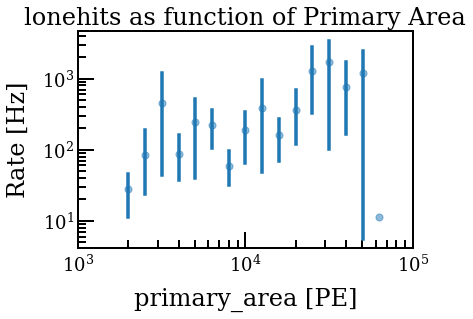

In [83]:
bins = 10 ** (np.arange(np.log10(2e3), np.log10(1e5) + 0.1, 0.1))
sns.regplot(data=data_sp, x=data_sp['area_primary'], y=data_sp['rate'], x_bins=bins, scatter_kws={'alpha': 0.5}, fit_reg=False)
plt.xlabel('primary_area [PE]')
plt.ylabel('Rate [Hz]')
plt.xscale('log')
plt.yscale('log')
plt.title('lonehits as function of Primary Area')
plt.xlim(1e3,1e5)
plt.show()

In [62]:
data_sp_liquid['count'] = data_sp_liquid.groupby('gcenter_time_primary')['gcenter_time_primary'].transform('count')
data_sp_liquid = data_sp_liquid.drop_duplicates(subset='gcenter_time_primary')

In [63]:
data_sp_liquid['time_considered'] = data_sp_liquid['livetime_new'].clip(upper=0.18) - 0.002
data_sp_liquid['rate'] = data_sp_liquid['count']/data_sp_liquid['time_considered']

In [72]:
max(data_sp_liquid['time_considered'])

0.17799999999999999

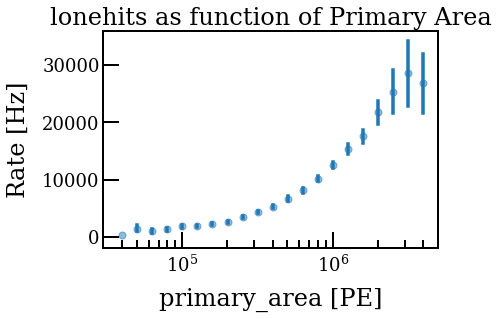

In [67]:
bins = 10 ** (np.arange(np.log10(4e4), np.log10(5e6) + 0.1, 0.1))
sns.regplot(data=data_sp_liquid, x=data_sp_liquid['area_primary'], y=data_sp_liquid['rate'], x_bins=bins, scatter_kws={'alpha': 0.5}, fit_reg=False)
plt.xlabel('primary_area [PE]')
plt.ylabel('Rate [Hz]')
plt.xscale('log')
#plt.yscale('log')
plt.title('lonehits as function of Primary Area')
plt.xlim(3e4,5e6)
plt.show()

In [61]:
data_sp_liquid.keys()

Index(['area', 'area_fraction_top_primary', 'area_primary', 'area_sum_primary',
       'center_time', 'dt_primary', 'event_number', 'gcenter_time',
       'gcenter_time_primary', 'largest_hit_channel_primary',
       'lone_hit_channel', 'run_number', 'type_digit', 'wr_avg_primary',
       'x_primary', 'y_primary', 'carea_primary', 'goodness_of_fit_primary',
       'livetime_new', 'time_pre_1', 'ClusterCut_power', 'livetime_old',
       'CutOverlap', 'event_window_seconds', 'delay_time_seconds'],
      dtype='object')

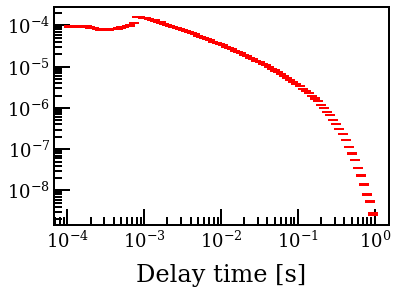

/depot/darkmatter/etc/conda/env/analysis/lib/python3.4/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


18157


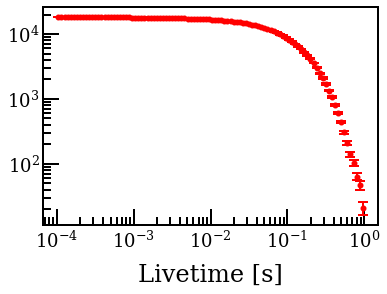

Optimization terminated successfully.
         Current function value: -184482546.946147
         Iterations: 164
         Function evaluations: 304


In [188]:
#rate_g, rate_err_g, bin_centers, centers_fit, results_g = get_frac(data_sp_gas, data_cut_gas)
rate_l, rate_err_l, bin_centers, centers_fit, results_l= get_frac(data_sp_liquid, data_cut_liquid)


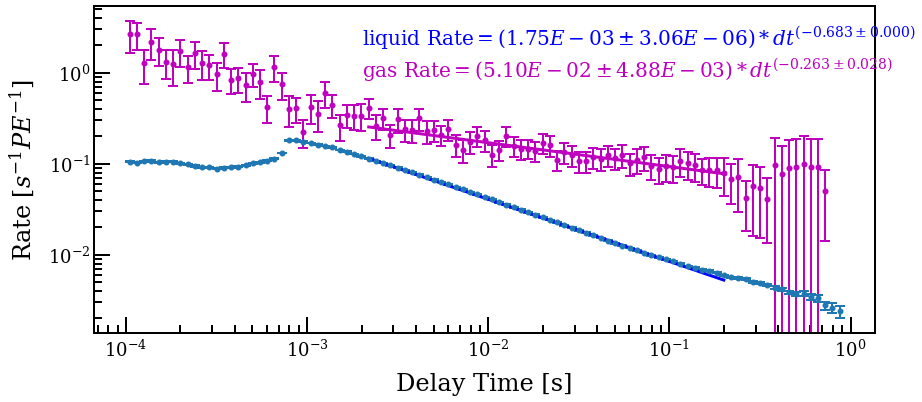

In [193]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers[:-1],rate_l[:-1], yerr=rate_err_l[:-1], fmt='.' ,drawstyle = 'steps-mid',label='lonehits due to liquid S2s')
l1 = ('liquid Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_l[0], results_l[2], results_l[1], results_l[3]))
plt.annotate(l1, xy=(2e-3, 2e0), fontsize=20, color='b')
curvey1 = power(centers_fit, results_l[0],results_l[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='b')

plt.errorbar(bin_centers[:-1],rate_g[:-1], yerr=rate_err_g[:-1],color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid',label='lonehits due to gas S2s')
l1 = ('gas Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_g[0], results_g[2], results_g[1], results_g[3]))
plt.annotate(l1, xy=(2e-3, 9e-1), fontsize=20, color='m')
curvey1 = power(centers_fit,results_g[0],results_g[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$ s^{-1} PE^{-1}$]')
# plt.ylim(1e-6,1e1)
#plt.legend(loc=3)
plt.xticks()
plt.yticks()
plt.show()

In [50]:
data_sp_bottom = data_sp_liquid[data_sp_liquid['lone_hit_channel']>126]
data_sp_top = data_sp_liquid[data_sp_liquid['lone_hit_channel']<127]

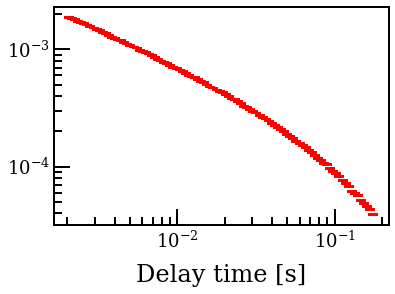

/depot/darkmatter/etc/conda/env/analysis/lib/python3.4/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


18750


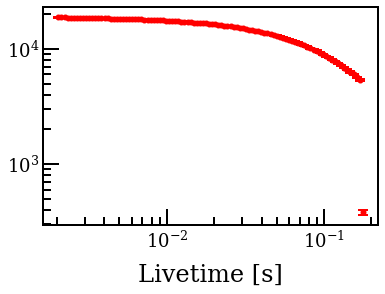

Optimization terminated successfully.
         Current function value: -107204133.911971
         Iterations: 171
         Function evaluations: 316


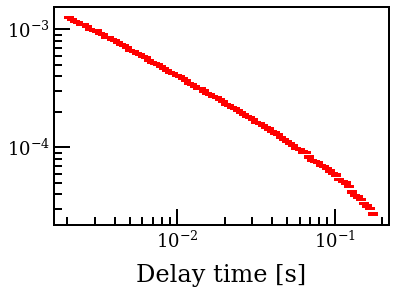

18750


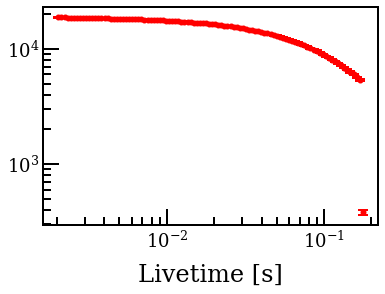

Optimization terminated successfully.
         Current function value: -56626984.612564
         Iterations: 164
         Function evaluations: 304


In [51]:
rate_b, rate_err_b, bin_centers, centers_fit, results_b= get_frac(data_sp_bottom, data_cut_liquid)
rate_t, rate_err_t, bin_centers, centers_fit, results_t= get_frac(data_sp_top, data_cut_liquid)


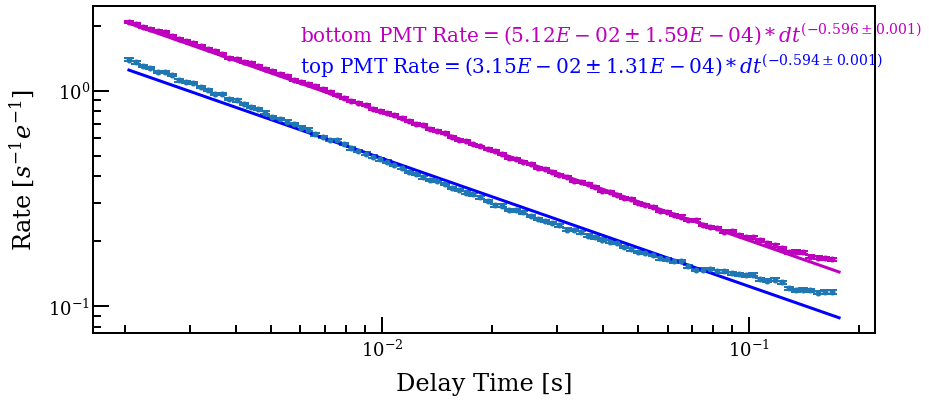

In [52]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers[:-1],rate_b[:-1], yerr=rate_err_b[:-1],color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid',label='lonehits due to gas S2s')
l1 = ('bottom PMT Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_b[0], results_b[2], results_b[1], results_b[3]))
plt.annotate(l1, xy=(6e-3, 1.7e0), fontsize=20, color='m')
plt.errorbar(bin_centers[:-1],rate_t[:-1], yerr=rate_err_t[:-1], fmt='.' ,drawstyle = 'steps-mid',label='lonehits due to liquid S2s')
l1 = ('top PMT Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_t[0], results_t[2], results_t[1], results_t[3]))
plt.annotate(l1, xy=(6e-3, 1.2e0), fontsize=20, color='b')
curvey1 = power(centers_fit,results_b[0],results_b[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')
curvey1 = power(centers_fit, results_t[0],results_t[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='b')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$ s^{-1} e^{-1}$]')
# plt.ylim(1e-6,1e1)
#plt.legend(loc=3)
plt.xticks()
plt.yticks()
plt.show()

In [53]:
del data_sp_top, data_sp_bottom

In [54]:
data_sp_inner = data_sp_liquid[data_sp_liquid['x_primary']**2+data_sp_liquid['y_primary']**2<15**2]

In [57]:
data_sp_inner_centerPMT = data_sp_inner[(data_sp_inner['lone_hit_channel']>119)&(data_sp_inner['lone_hit_channel']<127)]
data_sp_inner_outerPMT = data_sp_inner[data_sp_inner['lone_hit_channel']<66]

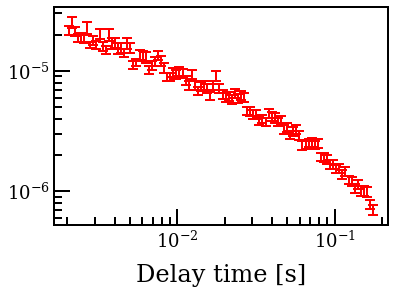

/depot/darkmatter/etc/conda/env/analysis/lib/python3.4/site-packages/ipykernel/__main__.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


18750


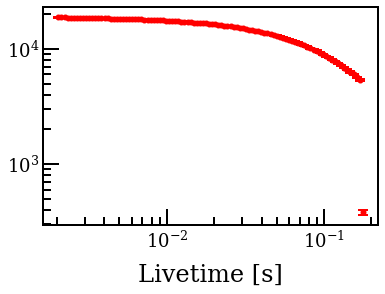

Optimization terminated successfully.
         Current function value: -806973.720231
         Iterations: 150
         Function evaluations: 271


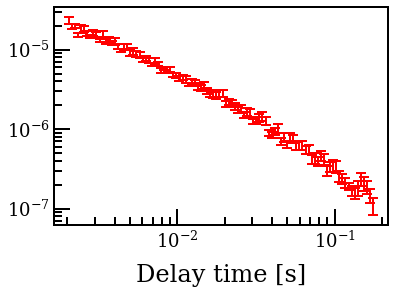

18750


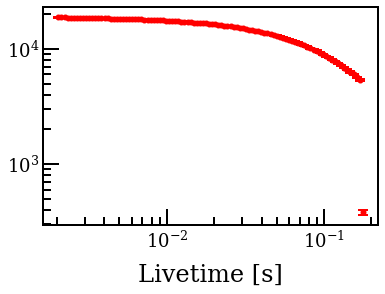

Optimization terminated successfully.
         Current function value: -393929.595612
         Iterations: 153
         Function evaluations: 274


In [58]:
rate_u, rate_err_u, bin_centers, centers_fit, results_u= get_frac(data_sp_inner_outerPMT, data_cut_liquid)
rate_c, rate_err_c, bin_centers, centers_fit, results_c= get_frac(data_sp_inner_centerPMT, data_cut_liquid)

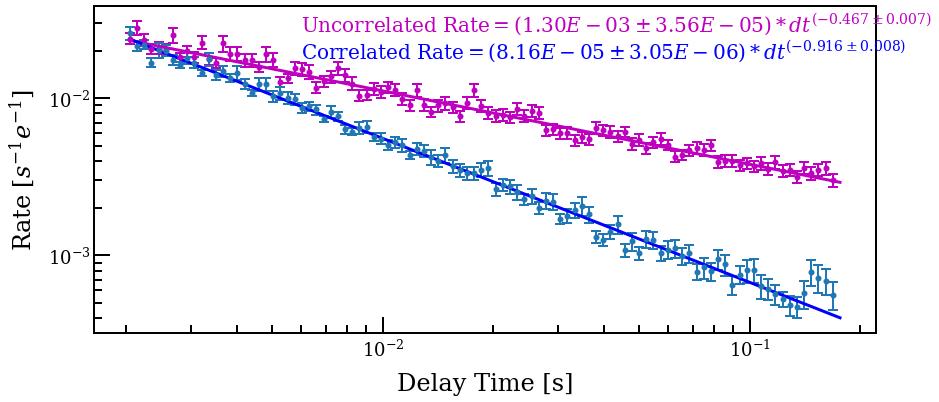

In [59]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers[:-1],rate_u[:-1], yerr=rate_err_u[:-1],color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid',label='lonehits due to gas S2s')
l1 = ('Uncorrelated Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_u[0], results_u[2], results_u[1], results_u[3]))
plt.annotate(l1, xy=(6e-3, 2.7e-2), fontsize=20, color='m')
plt.errorbar(bin_centers[:-1],rate_c[:-1], yerr=rate_err_c[:-1], fmt='.' ,drawstyle = 'steps-mid',label='lonehits due to liquid S2s')
l1 = ('Correlated Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_c[0], results_c[2], results_c[1], results_c[3]))
plt.annotate(l1, xy=(6e-3, 1.8e-2), fontsize=20, color='b')
curvey1 = power(centers_fit,results_u[0],results_u[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='m')
curvey1 = power(centers_fit, results_c[0],results_c[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3, color='b')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$ s^{-1} e^{-1}$]')
# plt.ylim(1e-6,1e1)
#plt.legend(loc=3)
plt.xticks()
plt.yticks()
plt.show()